## 对ID和OOD样本进行softmax可视化以及标准差分析

In [1]:
# tensorflowGPU的设置
import tensorflow as tf

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
# 在同时具有CPU和GPU的设备上，优先使用GPU运算, 实际中可以使用with tf.device创建设备上下文
# 例如： with tf.decice('/CPU:0'): 
# 限制内存增长
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
def pad_data(res, max_len=2850):
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def train_data_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 6000]
        labels = labels[: 6000]
    elif mode == 'val':    
        codes = codes[6000: ]
        labels = labels[6000: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]
        
        
def train_data_loader(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 6000]
        labels = labels[: 6000]
    elif mode == 'val':    
        codes = codes[6000: ]
        labels = labels[6000: ]
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res


def codes_loader(codes):
    
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all)


def codes_generator(codes):
    
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res
        
        
def svmdata_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 268]
        labels = labels[: 268]
    elif mode == 'val':    
        codes = codes[268: 468]
        labels = labels[268: 468]
    
    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [4]:
# 利用labelencoder构建opcode编码器

from sklearn import preprocessing
from tqdm import tqdm

data_csv = pd.read_csv('res_handle.csv')
opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)
len(list(le.classes_))

100%|██████████| 12402/12402 [00:05<00:00, 2081.72it/s]


641

In [5]:
from utils import *
ood2label = {True: 0, False: 1}
data_test_1 = pd.read_csv('data_test_1.csv')
data_ood = data_test_1[data_test_1['id']==False]
path_ood = data_ood['name'].to_list()
codes_odd = codes_loader(path_ood)

model_random = keras.models.load_model('./model/textcnn_split.h5')
logits_ood = model_random.predict(codes_odd)
soft_ood = keras.backend.softmax(logits_ood)
soft_ood = soft_ood.numpy()
soft_ood = np.max(soft_ood, axis=1)

100%|██████████| 201/201 [00:00<00:00, 214.29it/s]


In [6]:
data_id = data_test_1[data_test_1['id']==True]
path_id = data_id['name'].to_list()
codes_id = codes_loader(path_id)

model_random = keras.models.load_model('./model/textcnn_split.h5')
logits_id = model_random.predict(codes_id)
soft_id = keras.backend.softmax(logits_id)
soft_id = soft_id.numpy()
soft_id = np.max(soft_id, axis=1)

100%|██████████| 1648/1648 [00:10<00:00, 153.46it/s]


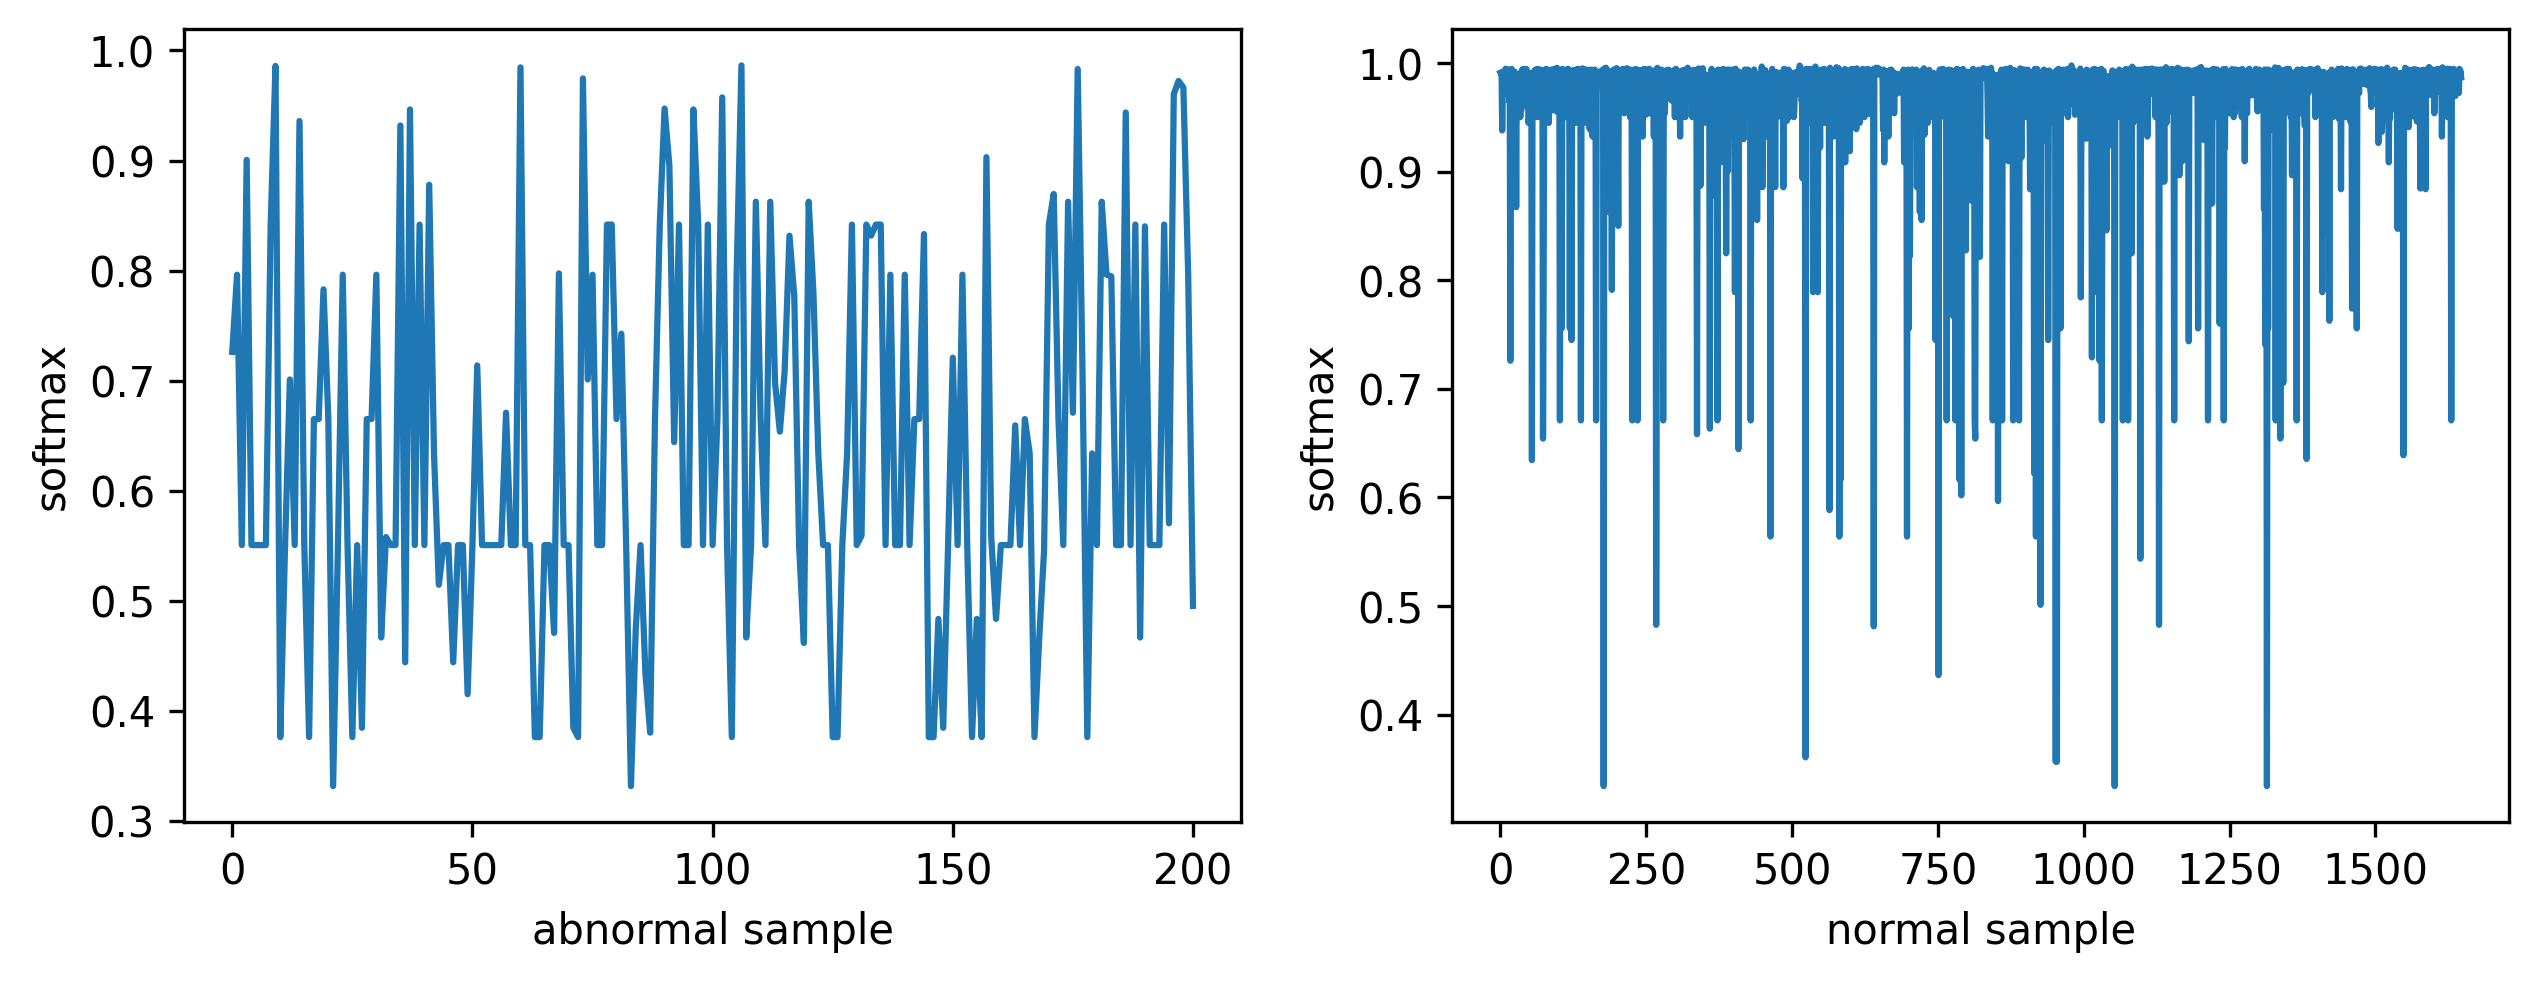

In [9]:
data_id = pd.DataFrame(soft_id, columns=['id'])
data_ood = pd.DataFrame(soft_ood, columns=['id'])

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 3.5),dpi=300)
ax = fig.add_subplot(121)
sns.lineplot(data=data_ood['id'], ax=ax)
plt.ylabel("softmax")
plt.xlabel("abnormal sample")

ax = fig.add_subplot(122)
sns.lineplot(data=data_id['id'], ax=ax)
plt.ylabel("softmax")
plt.xlabel("normal sample")
plt.savefig("./figures/entropy_analyse.png")

In [10]:
print(np.std(soft_id))
print(np.std(soft_ood))

0.07991362
0.17061251
